In [8]:
from collections import Counter, defaultdict
from datasets import Dataset, load_from_disk, DatasetDict, concatenate_datasets, load_dataset, Features, Value, interleave_datasets
from IPython.display import clear_output
from gpt_wrapper.chat import Chat
from tqdm import tqdm

import gpt_wrapper
import json
import jsonlines
import matplotlib.pyplot as plt
import os
import pandas as pd
import random 
import re
import scienceplots

api_keys = [
    "7a1ed46e-6371-445e-a383-cc6ccf0525fd",
    "4eadeb76-03d6-40cc-b858-27b0da441ac5",
    "175accd9-4b3d-42a7-998e-85600fa3d1f4"
]

gpt_wrapper.api_base = "http://mnlp-backend-938795011.eu-central-1.elb.amazonaws.com"
gpt_wrapper.api_key = "175accd9-4b3d-42a7-998e-85600fa3d1f4"

def set_api_key(index):
    try:
        gpt_wrapper.api_key = api_keys[index]
    except IndexError:
        raise Exception("All API keys have exhausted their credits or are invalid.")


# pedro: 175accd9-4b3d-42a7-998e-85600fa3d1f4
# Andre: 4eadeb76-03d6-40cc-b858-27b0da441ac5
# Pierre: 7a1ed46e-6371-445e-a383-cc6ccf0525fd

## TOC
1. Process / Extract MC questions
2. Create DPO preference pairs using GPT API
3. Create Interleaved Train and Test datasets
    - Save Train and Test Datasets
    - Add Source Column to Datasets
    - Add Topic Column to Datasets
    - Post-process Platypus/MMLU/EPFL datasets 
    - Map entries in each training set to the found source/topic
4. Create MCQ Dataset for M2
    - Add `explanation` column to both datasets (fill it with "explanation"/"support") from source datasets
    - Remove entries with empty `explanation` column
    - Remove entries with `explanation` column not related to `question` column (SciQ dataset)
5. Visualizing Datasets
666. Graveyard

## Process / Extract MC questions

In [14]:
# arxiv-physics["train"] had 0 MC questions
# arxiv-physics["test"] had 0 MC questions
# MMLU-STEM_final["train"] has 40 potential MC questions
# MMLU-STEM_final["test"] has 6 potential MC questions
# open_platypus_final["train"] has 500 potential MC questions
# open_platypus_final["test"] has 130 potential MC questions
# epfl_all_final["train"] has 878 potential MC questions
# epfl_all_final["test"] has 209 potential MC questions


def is_possible_mc(question):
    # This pattern checks for two main formats:
    # 1. An optional "Options:" prefix (non-capturing group with `?:` and `?` for optional).
    # 2. A sequence of choice entries starting with A-Z wrapped in parentheses.
    pattern = re.compile(r"(?:\bOptions:\s*)?(\([A-Za-z]\)\s*.*?){2,}", re.IGNORECASE)
    return bool(pattern.search(question))

#dataset = load_from_disk("../data/MMLU-STEM_final")["train"]
#dataset = load_from_disk("../data/open_platypus_final")["train"]
#dataset = load_from_disk("../data/arxiv-physics-instruct-tune-30k_final")["train"]
#dataset = load_from_disk("../data/epfl_all_final")["train"]

dataset_train = load_from_disk("../data/MMLU-STEM_final")["train"]
dataset_test = load_from_disk("../data/MMLU-STEM_final")["test"]
dataset = concatenate_datasets([dataset_train, dataset_test])
dataset = dataset.add_column("id", range(len(dataset)))  # Add an ID column to the dataset

filtered_dataset = dataset.filter(lambda example: is_possible_mc(example['question']))
non_mcq_dataset = dataset.filter(lambda example: not is_possible_mc(example['question']))

# Filter dataset to only take 10 first entries
#filtered_dataset = filtered_dataset.select(list(range(5)))

print(filtered_dataset)
print(non_mcq_dataset)

Dataset({
    features: ['choices', 'topic', 'correct_choice', 'question', 'answer', 'id'],
    num_rows: 46
})
Dataset({
    features: ['choices', 'topic', 'correct_choice', 'question', 'answer', 'id'],
    num_rows: 3088
})


In [110]:
def extract_choices(question):
    template = '''
    Think step by step. Please analyze the provided question. If (and only if) it's a multiple-choice question, extract and format the choices from the question text as in the Output format.
    Output format:
    Question: {question}
    Choices: [A: choice1, B: choice2, ...]
    
    Example 1:
    Question: What is 2+2?
    Choices: [A: 3, B: 4, C: 5, D: 6]
    
    Example 2:
    Question: What is the capital of France?
    Choices: [A: Paris, B: Berlin, C: London, D: Madrid]

    If not a multiple-choice question, return the question unmodified.
    '''
    prompt = template.format(question=question)
    chat = Chat.create(f"mcq_{random.randint(0, 999999999999)}")
    message = chat.ask(content=prompt)
    return str(message)


def extract_correct_choice(answer, choices):
    template = '''
    Let's think step by step. Given this answer from a multiple-choice question, identify the correct choice's index from the list of choices {choices}. Analyze the provided answer text and return only the index of the correct choice (as an integer starting from 0).
    Output format:
    List of choices: {choices}
    Answer: {answer}
    Correct choice index: <index>
    
    Example 1: 
    List of choices: [A: 3, B: 4, C: 5, D: 6]
    Answer: "The correct answer is B."
    Correct choice index: 1

    Example 2:
    List of choices: [A: Paris, B: Berlin, C: London, D: Madrid]
    Answer: "The capital of France is A."
    Correct choice index: 0

    '''
    prompt = template.format(answer=answer, choices=choices)
    chat = Chat.create(f"mcq_{random.randint(0, 999999999999)}")
    message = chat.ask(content=prompt)

    # Convert the message to string and find integers in the result
    response_string = str(message)
    # Using regular expression to find all integers in the response string
    match = re.search(r'\b(\d+)\b', response_string)
    
    if match:
        # Return the integer found as the position
        return int(match.group(1))
    else:
        return None


def letter_to_index(letter):
    # Assuming letter is 'A', 'B', 'C', ..., 'Z'
    return ord(letter.upper()) - ord('A')


# Function to update MCQ entries with extracted choices and correct choice
def update_mcq_entry(entry):
    if 'choices' in entry and entry['choices'] is not None and 'correct_choice' in entry and entry['correct_choice'] is not None:
        # If 'correct_choice' is a string and represents a letter, convert it to index
        if isinstance(entry['correct_choice'], str) and entry['correct_choice'].isalpha():
            entry['correct_choice'] = letter_to_index(entry['correct_choice'])
        # If 'correct_choice' is already an int no need to change it
        # We assume that existing integer values are correctly formatted
        entry['reprocess'] = False
        return entry

    # Extract the full text containing choices
    full_choice_text = extract_choices(entry['question'])
    
    # Check if "Choices:" is present in the text
    if "Choices:" in full_choice_text:
        # Split the text at "Choices:" and take the second part, which contains the choices
        entry['choices'] = full_choice_text.split("Choices:")[1].strip()
    else:
        # If "Choices:" is not found, set choices to None
        entry['choices'] = None
    
    # Extract the index of the correct choice from the answer
    entry['correct_choice'] = extract_correct_choice(entry['answer'], entry['choices'])
    entry['reprocess'] = False  # Default to False for manual verification later

    return entry


def reset_entry(entry):
    entry['choices'] = None
    entry['correct_choice'] = None
    entry['reprocess'] = True
    return entry

In [111]:
# Map function to update entries
updated_mcqs = filtered_dataset.map(update_mcq_entry)

# Save updated_mcqs to jsonl
updated_mcqs.to_json("../data_processing/verified_mcqs.jsonl", orient="records", lines=True)

# Save non_mcq_dataset to jsonl
non_mcq_dataset.to_json("../data_processing/non_mcqs.jsonl", orient="records", lines=True)

Creating json from Arrow format: 100%|██████████| 4/4 [00:00<00:00, 112.54ba/s]


4010594

In [112]:
def main_loop():
    # Load the verified MCQs and non-MCQs datasets
    verified_mcqs = load_dataset("json", data_files="../data_processing/verified_mcqs.jsonl")['train']
    
    non_mcq_list = []
    verified_list = []
    reprocess_list = []
    
    # Perform initial verification of each entry
    for entry in verified_mcqs:
        print(f"Initial review of entry ID {entry['id']}")
        print(f"Question: {entry['question']}")
        print(f"Choices: {entry['choices']}")
        print(f"Correct choice: {entry['correct_choice']}")
        print(f"Answer: {entry['answer']}")
        
        is_mcq_user = input("Is this a multiple choice question? (y/n): ").strip().lower()
        if is_mcq_user == 'n':
            entry['is_mcq'] = False
            entry['choices'] = None
            entry['correct_choice'] = None
            non_mcq_list.append(entry)
        elif is_mcq_user == 'y':
            user_decision = input("Is this entry correct? (y/n): ").strip().lower()
            if user_decision == 'y':
                entry['reprocess'] = False
                verified_list.append(entry)
            elif user_decision == 'n':
                entry['reprocess'] = True
                reprocess_list.append(entry)
        clear_output(wait=True)
    print("-----------------Initial review completed-----------------")
    clear_output(wait=True)

    # Save the updated MCQs
    with open("../data_processing/verified_mcqs.jsonl", 'w') as f:
        for mcq in verified_list:
            f.write(json.dumps(mcq) + '\n')

    # Save the updated non-MCQs
    with open("../data_processing/non_mcqs.jsonl", 'w') as f:
        for non_mcq in non_mcq_list:
            f.write(json.dumps(non_mcq) + '\n')

    # Reprocessing loop
    while reprocess_list:
        # Print the number of entries to reprocess
        print(f"Number of entries being reprocessed: {len(reprocess_list)}")
        reprocessed_entries = [update_mcq_entry(entry) for entry in reprocess_list]
        reprocess_list = []

        # Manual verification of reprocessed entries
        for entry in reprocessed_entries:
            print(f"Reviewing reprocessed entry ID {entry['id']}")
            print(f"Question: {entry['question']}")
            print(f"Answer: {entry['answer']}")
            print(f"Choices: {entry['choices']}")
            print(f"Correct choice: {entry['correct_choice']}")
            user_decision = input("Is this entry correct? (y/n): ").strip().lower()
            if user_decision == 'y':
                verified_list.append(entry)
            elif user_decision == 'n':
                reprocess_list.append(reset_entry(entry))
            clear_output(wait=True)

        # Save updated verified MCQs
        with open("../data_processing/verified_mcqs.jsonl", 'w') as f:
            for mcq in verified_list:
                f.write(json.dumps(mcq) + '\n')
        print("Verified MCQs updated.")
        
        print("Would you like to continue reprocessing?")
        # Break condition based on user input
        if input("Continue processing? (y/n): ").lower() == 'n':
            break
            # Add logic to drop the remaining entries as these are most likely not correct
        else:
            print("Reseting non-correct entries for reprocessing...")

In [ ]:
main_loop()

Generating train split: 46 examples [00:00, 19855.72 examples/s]


Initial review of entry ID 27
Question: PCl3(g) + Cl2(g) ↔ PCl5(g) ΔH = -92.5 kJ/mol In which of the following ways could the reaction above be manipulated to create more product?
Choices: ['Decreasing the concentration of PCl3', 'Increasing the pressure', 'Increasing the temperature', 'None of the above']
Correct choice: 1
Answer: First, let's look at Le Chatelier's principle, which states that if a system at equilibrium is subjected to a stress, the system will adjust in order to minimize the effect of that stress.

In this reaction, the formation of PCl5 is favored as the reaction is exothermic (ΔH = -92.5 kJ/mol). According to Le Chatelier's principle, if we increase the pressure, the system will shift towards the side with fewer moles of gas in order to decrease the pressure. In this case, PCl5 has fewer moles of gas compared to PCl3 and Cl2, so increasing the pressure will shift the reaction towards the formation of more PCl5.

Therefore, increasing the pressure is the only corre

In [ ]:
# test

verified_mcqs = load_dataset("json", data_files="../data_processing/verified_mcqs.jsonl")['train']
print(verified_mcqs)

In [ ]:
# Check for duplicate IDs between the two datasets

verified_mcqs = load_dataset("json", data_files="../data_processing/verified_mcqs.jsonl")['train']

non_mcq_ids = non_mcq_dataset['id']
verified_mcq_ids = verified_mcqs['id']

overlap = set(non_mcq_ids).intersection(set(verified_mcq_ids))
print(f"Overlap count: {len(overlap)}")

In [ ]:
# Merge the non_mcq_ids and verified_mcq_ids Datasets
combined_dataset = concatenate_datasets([non_mcq_dataset, verified_mcqs])

# Remove the ID column
combined_dataset = combined_dataset.remove_columns("id")

# Display the updated dataset
print(combined_dataset)

## Create DPO preference pairs using GPT

In [35]:
def generate_response(entry, key_index=0):
    try:
        # Construct the prompt
        template = 'Please answer this question: "{}"'
        prompt = template.format(entry["question"])

        # Create a chat instance and send the prompt
        chat_id = f"chat_{random.randint(0, 999999999999)}"
        chat = Chat.create(chat_id)
        message = chat.ask(content=prompt)
        response_string = str(message)

        # Update the entry dictionary with the new response
        return {
            "prompt": entry["question"],
            "chosen": entry["answer"],
            "rejected": response_string
        }
    except Exception as e:
        if str(e) == "Out of credits" and key_index < len(api_keys) - 1:
            # Switch to the next API key if out of credits
            set_api_key(key_index + 1)
            return generate_response(entry, key_index + 1)
        else:
            # If all keys are exhausted or another error occurs
            raise

def process_dataset(dataset):
    # Set the first API key initially
    set_api_key(0)

    # Use the map method to process the dataset in parallel
    result = dataset.map(generate_response, num_proc=32)
    return result

def write_jsonl_file(dataset, filename):
    # Write the processed entries to a JSONL file
    with open(filename, 'w') as f:
        for entry in dataset:
            # filter entry to only include prompt, chosen, and rejected
            entry = {k: entry[k] for k in ["prompt", "chosen", "rejected"]}
            json_line = json.dumps(entry)
            f.write(json_line + '\n')

# Load the dataset and process it
#dataset = load_from_disk("../data/arxiv-physics-instruct-tune-30k_final")["train"]

dataset = load_from_disk("../data/arxiv-physics-instruct-tune-30k")["train"]
dataset_processed = process_dataset(dataset)
write_jsonl_file(dataset_processed, "../data/arxiv-physics-instruct-tune-30k_train_preference_pairs.jsonl")

Map (num_proc=32):   7%|▋         | 1006/15228 [03:38<55:38,  4.26 examples/s]  

Server timeout.
Retrying in 10 seconds...


Map (num_proc=32):  19%|█▉        | 2880/15228 [11:48<1:40:54,  2.04 examples/s]

Server timeout.
Retrying in 10 seconds...


Map (num_proc=32):  51%|█████     | 7767/15228 [39:52<46:47,  2.66 examples/s]  

Server timeout.
Retrying in 10 seconds...


Map (num_proc=32):  77%|███████▋  | 11759/15228 [57:26<10:11,  5.68 examples/s]  

Server timeout.
Retrying in 10 seconds...


Map (num_proc=32):  80%|████████  | 12196/15228 [59:03<08:49,  5.72 examples/s]

Server timeout.
Retrying in 10 seconds...


Map (num_proc=32):  94%|█████████▍| 14323/15228 [1:07:56<07:14,  2.08 examples/s]

Server timeout.
Retrying in 10 seconds...


Map (num_proc=32): 100%|██████████| 15228/15228 [1:14:29<00:00,  3.41 examples/s]


## Create Interleaved Train and Test datasets

- 20% of all 5 datasets (total of 15.955).
    - EPFL: 5324 (all: avg 17 preference pairs per unique prompt)
    - Platypus: 3807
    - Arxiv: 6047
    - Theoremqa: 150
    - MMLU: 627

- We have a total of 54.626 training examples.
    - EPFL: 12110 (10 preference pairs per unique prompt)
    - Platypus: 15228
    - Arxiv: 24184
    - Theoremqa: 597
    - MMLU: 2507

**Train set approaches:**
1. Combines all train data from the different files (54k rows).
2. Combines EPFL_train with the 4 other train datasets until 20k is reached
3. Combines EPFL_train with the 4 other train datasets until 30k is reached
4. Combines EPFL_train with the 4 other train datasets until 40k is reached
(5). If one of the lower splits performs better than the others, we could try to tweak the topic/dataset distribution of that split.

**Test set approaches:**
- All test data
    - Identify which topics it seems to have lower performance in.
- Only EPFL test data

## Create Interleaved Train and Test datasets

In [1]:
# Paths to datasets
paths = {
    "ArtifactAI/arxiv-physics-instruct-tune-30k": "../data/preference_pairs_by_GPT/arxiv-physics-instruct-tune-30k_preference_pairs_train.jsonl",
    "TIGER-Lab/MMLU-Pro": "../data/preference_pairs_by_GPT/MMLU-STEM_preference_pairs_train.jsonl",
    "garage-bAInd/Open-Platypus": "../data/preference_pairs_by_GPT/open_platypus_preference_pairs_train.jsonl",
    "TIGER-Lab/TheoremQA": "../data/preference_pairs_by_GPT/theoremqa_preference_pairs_train.jsonl",
    "epfl_m1_preference_pairs": "../data/M1_preference_data_train.jsonl"
}

output_paths = {
    "ArtifactAI/arxiv-physics-instruct-tune-30k": "../data/preference_pairs_by_GPT/arxiv_with_source.jsonl",
    "TIGER-Lab/MMLU-Pro": "../data/preference_pairs_by_GPT/mmlu_with_source.jsonl",
    "garage-bAInd/Open-Platypus": "../data/preference_pairs_by_GPT/platypus_with_source.jsonl",
    "TIGER-Lab/TheoremQA": "../data/preference_pairs_by_GPT/theoremqa_with_source.jsonl",
    "epfl_m1_preference_pairs": "../data/M1_preference_data_with_source.jsonl"
}

In [ ]:
def load_data(paths):
    data = {key: [] for key in paths}
    for key, path in paths.items():
        with jsonlines.open(path) as reader:
            for obj in reader:
                data[key].append(obj)
    return data

def create_train_dataset(data, datasets, max_len, seed=42):
    random.seed(seed)  # Set the random seed for reproducibility
    combined_data = []
    indexes = {key: 0 for key in datasets}  # Starting index for each dataset
    max_epfl_len = len(data['epfl'])  # All EPFL entries are included

    # First, add all EPFL data
    combined_data.extend(data['epfl'])

    # Now, add data from other datasets interleaving them
    while len(combined_data) < max_len:
        for dataset in datasets:
            if dataset != 'epfl' and indexes[dataset] < len(data[dataset]):
                combined_data.append(data[dataset][indexes[dataset]])
                indexes[dataset] += 1
                if len(combined_data) >= max_len:
                    break

    # Shuffle the combined data to randomize the order of entries
    random.shuffle(combined_data)
    return combined_data[:max_len]  # Return only up to max_len items

# Load all data
data = load_data(paths)

# Create datasets
train_all = create_train_dataset(data, paths.keys(), (sum([len(data[key]) for key in data])))
train_20k = create_train_dataset(data, paths.keys(), 20000)
train_30k = create_train_dataset(data, paths.keys(), 30000)
train_40k = create_train_dataset(data, paths.keys(), 40000)

# Example to save one of the datasets to a new JSON Lines file
# with jsonlines.open('../data/combined_20k_train.jsonl', mode='w') as writer:
#     writer.write_all(train_20k)
# with jsonlines.open('../data/combined_30k_train.jsonl', mode='w') as writer:
#     writer.write_all(train_30k)
# with jsonlines.open('../data/combined_40k_train.jsonl', mode='w') as writer:
#     writer.write_all(train_40k)
# with jsonlines.open('../data/combined_all_train.jsonl', mode='w') as writer:
#     writer.write_all(train_all)

In [52]:
# Combine all test datasets
def load_data(paths):
    data = {key: [] for key in paths}
    for key, path in paths.items():
        with jsonlines.open(path) as reader:
            for obj in reader:
                data[key].append(obj)
    return data

def create_test_dataset(data, datasets, only_epfl=False):
    combined_data = []
    if only_epfl:
        # If only EPFL data is required, return all EPFL entries
        combined_data = data['epfl_test']
    else:
        # Combine all datasets into one
        for dataset in datasets:
            combined_data.extend(data[dataset])

    random.shuffle(combined_data)  # Shuffle the combined data
    return combined_data

# Paths to your test datasets
test_paths = {
    "arxiv_test": "../data/preference_pairs_by_GPT/arxiv-physics-instruct-tune-30k_preference_pairs_test.jsonl",
    "mmlu_test": "../data/preference_pairs_by_GPT/MMLU-STEM_preference_pairs_test.jsonl",
    "platypus_test": "../data/preference_pairs_by_GPT/open_platypus_preference_pairs_test.jsonl",
    "theoremqa_test": "../data/preference_pairs_by_GPT/theoremqa_preference_pairs_test.jsonl",
    "epfl_test": "../data/M1_preference_data_test.jsonl"
}

# Load all test data
test_data = load_data(test_paths)

# Create test datasets
test_epfl = create_test_dataset(test_data, test_paths.keys(), only_epfl=True)
test_combined = create_test_dataset(test_data, test_paths.keys(), only_epfl=False)

# Example to save one of the datasets to a new JSON Lines file
with jsonlines.open('../data/combined_test.jsonl', mode='w') as writer:
    writer.write_all(test_combined)
with jsonlines.open('../data/epfl_test.jsonl', mode='w') as writer:
    writer.write_all(test_epfl)


### Save Train and Test Datasets

In [ ]:
def load_data(paths):
    data = {key: [] for key in paths}
    for key, path in paths.items():
        with jsonlines.open(path) as reader:
            for obj in reader:
                data[key].append(obj)
    return data

def create_train_dataset(data, datasets, max_len, seed=42):
    random.seed(seed)  # Set the random seed for reproducibility
    combined_data = []
    indexes = {key: 0 for key in datasets}  # Starting index for each dataset
    max_epfl_len = len(data['epfl'])  # All EPFL entries are included

    # First, add all EPFL data
    combined_data.extend(data['epfl'])

    # Now, add data from other datasets interleaving them
    while len(combined_data) < max_len:
        for dataset in datasets:
            if dataset != 'epfl' and indexes[dataset] < len(data[dataset]):
                combined_data.append(data[dataset][indexes[dataset]])
                indexes[dataset] += 1
                if len(combined_data) >= max_len:
                    break

    # Shuffle the combined data to randomize the order of entries
    random.shuffle(combined_data)
    return combined_data[:max_len]  # Return only up to max_len items



In [ ]:
# Load all data
data = load_data(paths)

# Create datasets
train_all = create_train_dataset(data, paths.keys(), (sum([len(data[key]) for key in data])))
train_20k = create_train_dataset(data, paths.keys(), 20000)
train_30k = create_train_dataset(data, paths.keys(), 30000)
train_40k = create_train_dataset(data, paths.keys(), 40000)

# Example to save one of the datasets to a new JSON Lines file
# with jsonlines.open('../data/combined_20k_train.jsonl', mode='w') as writer:
#     writer.write_all(train_20k)
# with jsonlines.open('../data/combined_30k_train.jsonl', mode='w') as writer:
#     writer.write_all(train_30k)
# with jsonlines.open('../data/combined_40k_train.jsonl', mode='w') as writer:
#     writer.write_all(train_40k)
# with jsonlines.open('../data/combined_all_train.jsonl', mode='w') as writer:
#     writer.write_all(train_all)

### Add Source Column to Datasets

**Visualize dataset/topic distributions**
Add column with "source" to all preference dataset files, e.g. in EPFL dataset, each line will have the column "source" = "EPFL". Then in the combined datasets, we can find what percentage comes from which datasets (Stacked Bar Chart). If we have a percentage split of topics from each dataset, this will give us a rough idea of the topic distributions in each dataset. **This might be useful for testing** since we can see which dataset sources / topics our model performs well/poorly on.

- For this we need a unique ID for each prompt in each dataset, and each unique id should have a "topic" linked to it.

In [50]:
# Add source column to datasets

def load_data_with_source(paths):
    data = {key: [] for key in paths}
    for key, path in paths.items():
        with jsonlines.open(path) as reader:
            for obj in reader:
                # Add source information to each entry
                obj['source'] = key
                data[key].append(obj)
    return data

def save_data_with_source(data, output_paths):
    for key, entries in data.items():
        with jsonlines.open(output_paths[key], mode='w') as writer:
            writer.write_all(entries)

# Load data and add source to each entry
data_with_source = load_data_with_source(paths)

# Save the modified data to new files
save_data_with_source(data_with_source, output_paths)

### Add Topic Column to Datasets
- Add same topic to all entries
    - **Arxiv Physics Instruct Tune 30k** Dataset: Physics
    - **TheoremQA** Dataset: Math
- Add topic using source dataset "Category"
    - **Open Platypus** Dataset: Math, Code, Physics, Random
- Add topic using GPT
    - **MMLU** Dataset: Easiest to prompt
    - **EPFL** Dataset: Easiest to Prompt

**Prompt GPT to assign each question to a topic** among our topic list.
Add it as a column to each entry, and visualize the topics of each dataset split.
- For EPFL data, process only unique prompts, and when the topic is found for a prompt, assign all entries that have identical prompt to the same topic.
- For 4 other datasets, process each entry and assign to topic.
    - Prompt GPT with very clear template.
- Take as input the jsonl, output new jsonl with "topic" column.
    - Rerun the create_train_dataset on the jsonl datasets with new "source" and "topic" columns, and check if the entries are the same (using the same seed). Since we want to hand in jsonl files in the format: (prompt, chosen, rejected) and not (prompt, chosen, rejected, source, topic)

In [32]:
# Load the Arxiv Physics dataset

jsonl_data_path = "../data/preference_pairs_by_GPT/arxiv_with_source.jsonl"
updated_jsonl_data_path = "../data/preference_pairs_by_GPT/arxiv_with_source_and_topic.jsonl"

arxiv_with_source_and_topic = []

# Load the original data
with jsonlines.open(jsonl_data_path) as reader:
    for obj in reader:
        obj['topic'] = 'Physics'  # Add the topic field with value 'Physics'
        arxiv_with_source_and_topic.append(obj)

# Save the updated data
with jsonlines.open(updated_jsonl_data_path, mode='w') as writer:
    writer.write_all(arxiv_with_source_and_topic)

In [15]:
# Load the TheoremQA dataset
jsonl_data_path = "../data/preference_pairs_by_GPT/theoremqa_with_source.jsonl"
updated_jsonl_data_path = "../data/preference_pairs_by_GPT/theoremqa_with_source_and_topic.jsonl"

theoremqa_with_source_and_topic = []

# Load the original data
with jsonlines.open(jsonl_data_path) as reader:
    for obj in reader:
        obj['topic'] = 'Math'  # Add the topic field with value 'Math'
        theoremqa_with_source_and_topic.append(obj)

# Save the updated data
with jsonlines.open(updated_jsonl_data_path, mode='w') as writer:
    writer.write_all(theoremqa_with_source_and_topic)

In [20]:
# Platypus
# Prompt the topic == 'random' take the others from: math, code, physics

# Open the JSONL file from ../data/jsonldata.jsonl
jsonl_data = []
with jsonlines.open('../data/preference_pairs_by_GPT/platypus_with_source.jsonl') as reader:
    for obj in reader:
        jsonl_data.append(obj)

dataset = load_dataset("garage-bAInd/Open-Platypus", split="train")
dataset_math = dataset.filter(lambda x: x['data_source'] in ['MATH/PRM-800K', 'ARB'])
dataset_code = dataset.filter(lambda x: x['data_source'] in ['leetcode_ne', 'tigerbot-kaggle'])
dataset_physics = dataset.filter(lambda x: x['data_source'] in ['scienceqa', 'scibench'])
dataset_random = dataset.filter(lambda x: x['data_source'] in ['airoboros'])


def search_topic(prompt, datasets, topic_name):
    for entry in datasets:
        if prompt in entry['instruction']:
            return topic_name
    return None

# Update JSONL data with topics
for entry in tqdm(jsonl_data, desc="Processing JSONL Entries"):
    prompt = entry['prompt']
    # Search in each dataset
    if topic := search_topic(prompt, dataset_math, "Math"):
        entry['topic'] = topic
    elif topic := search_topic(prompt, dataset_code, "Code"):
        entry['topic'] = topic
    elif topic := search_topic(prompt, dataset_physics, "Physics"):
        entry['topic'] = topic
    elif topic := search_topic(prompt, dataset_random, "Random"):
        entry['topic'] = topic
    else:
        entry['topic'] = None

# Save or print updated data
# with open('../data/preference_pairs_by_GPT/platypus_with_source_and_topic.jsonl', 'w') as file:
#     for entry in jsonl_data:
#         json.dump(entry, file)
#         file.write('\n')

In [28]:
# Process the EPFL dataset to only contain Unique Prompts
# Run the extract_topic, process_dataset, write_jsonl_file on the unique prompt EPFL dataset
# Once the Topic is found for each unique prompts, Map the topic to prompts in original dataset

def read_data(file_path):
    data_with_source = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            data_with_source.append(obj)
    return data_with_source

# Extract unique prompts from data
def get_unique_prompts(data):
    unique_prompts = {}
    for entry in data:
        prompt = entry['prompt']
        if prompt not in unique_prompts:
            unique_prompts[prompt] = entry
    return list(unique_prompts.values())

def extract_topic(entry):
    topics = ["Physics", "Math", "Computer Science", "Code", "AI"]
    template = """
    Given the following question: '{}' Please determine the most relevant academic or technical topic from the following options: {}. 
    Respond in the format: "Topic: <chosen_topic>"
    """
    prompt = template.format(entry["prompt"], ", ".join(topics))
    
    # Create a chat instance and send the prompt
    chat_id = f"chat_{random.randint(0, 999999999999)}"
    chat = Chat.create(chat_id)
    message = chat.ask(content=prompt)
    response_string = str(message)
    
    # Process response to match it to one of the predefined topics
    for topic in topics:
        if topic in response_string:
            entry["topic"] = topic
            return entry
    entry["topic"] = "Unknown"  # Use "Unknown" if no topics match
    return entry
    
def process_dataset(unique_dataset):
    result = []
    for entry in unique_dataset:
        result.append(extract_topic(entry))
    return result

def map_topics_to_data(unique_data, full_data):
    topic_map = {entry['prompt']: entry['topic'] for entry in unique_data}
    for entry in full_data:
        entry['topic'] = topic_map[entry['prompt']]
    return full_data

# Function to write processed data to JSONL
def write_jsonl_file(dataset, filename):
    with jsonlines.open(filename, mode='w') as writer:
        writer.write_all(dataset)

file_path = '../data/M1_preference_data_with_source.jsonl'
output_file = '../data/M1_preference_data_with_source_and_topic.jsonl'


# data = read_data(file_path)
# unique_data = get_unique_prompts(data)
# processed_data = process_dataset(unique_data)
# full_data_with_topics = map_topics_to_data(processed_data, data)
# write_jsonl_file(full_data_with_topics, output_file)

# # Load the EPFL dataset
# epfl_data_with_source = []
# with jsonlines.open('../data/M1_preference_data_with_source.jsonl') as reader:
#     for obj in reader:
#         epfl_data_with_source.append(obj)
# print(epfl_data_with_source[0])

In [31]:
# MMLU
file_path = '../data/preference_pairs_by_GPT/mmlu_with_source.jsonl'
output_file = '../data/preference_pairs_by_GPT/mmlu_with_source_and_topic.jsonl'

# data = read_data(file_path)
# processed_data = process_dataset(data)
# full_data_with_topics = map_topics_to_data(processed_data, data)
# write_jsonl_file(full_data_with_topics, output_file)

In [75]:
# Print the distribution of topics in Platyplus dataset
def print_topic_distribution(jsonl_data_path):
    # Load the data from the JSONL file
    data_with_topics = []
    with jsonlines.open(jsonl_data_path) as reader:
        for obj in reader:
            data_with_topics.append(obj)

    # Calculate the distribution of topics
    topic_distribution = {}
    for obj in data_with_topics:
        topic = obj.get('topic', 'Unknown')  # Using 'Unknown' as a default if the 'topic' key is missing
        if topic in topic_distribution:
            topic_distribution[topic] += 1
        else:
            topic_distribution[topic] = 1

    # Print the distribution of topics
    for topic, count in topic_distribution.items():
        print(f"{topic}: {count}")

arxiv_data_path = "../data/preference_pairs_by_GPT/arxiv_with_source_and_topic.jsonl"
theoremqa_data_path = "../data/preference_pairs_by_GPT/theoremqa_with_source_and_topic.jsonl"
platypus_data_path = "../data/preference_pairs_by_GPT/platypus_with_source_and_topic.jsonl"
epfl_data_path = "../data/M1_preference_data_with_source_and_topic.jsonl"
mmlu_data_path = "../data/preference_pairs_by_GPT/mmlu_with_source_and_topic.jsonl"

print("Distribution in the updated Arxiv Physics dataset:")
print_topic_distribution(arxiv_data_path)

print("Distribution in the updated TheoremQA dataset:")
print_topic_distribution(theoremqa_data_path)

print("Distribution in the updated Platypus dataset:")
print_topic_distribution(platypus_data_path)

print("Distribution in the updated EPFL dataset:")
print_topic_distribution(epfl_data_path)

print("Distribution in the updated MMLU dataset:")
print_topic_distribution(mmlu_data_path)

# Take all the "Random" topics and run the GPT model to classify them into our Topic list: Math, Code, Physics, Computer Science, or Code


Distribution in the updated Arxiv Physics dataset:
Physics: 24184
Distribution in the updated TheoremQA dataset:
Math: 597
Distribution in the updated Platypus dataset:
Math: 11256
Physics: 1915
Computer Science: 669
Code: 1272
AI: 116
Distribution in the updated EPFL dataset:
Computer Science: 4964
Math: 2940
Physics: 2160
AI: 1764
Code: 282
Distribution in the updated MMLU dataset:
Math: 1078
Physics: 1067
Computer Science: 245
AI: 93
Code: 24


### Post-process Platypus/MMLU/EPFL datasets to re-process entries with the "Random"/"Unknown" topic

In [50]:
# Post-process the Platypus dataset to re-process entries with the "Unknown" topic 

def process_dataset_platypus(data):
    result = []
    for entry in data:
        if entry['topic'] == "Unknown":
            result.append(extract_topic(entry))
        else:
            result.append(entry)
    return result

# Platypus while loop to re-process entries with "Unknown" as the topic
file_path = '../data/preference_pairs_by_GPT/platypus_with_source_and_topic.jsonl'
continue_processing = input("Continue processing (yes/no)? ").strip().lower()

while continue_processing == "yes":
    data = read_data(file_path)
    processed_data = process_dataset_platypus(data)

    # Count entries still with "Unknown" as the topic
    unknown_count = sum(1 for entry in processed_data if entry['topic'] == "Unknown")
    print(f"Updated number of entries with 'Unknown' as topic: {unknown_count}")

    if unknown_count == 0:
        print("No more entries with 'Unknown' as topic. Writing to file and exiting.")
        write_jsonl_file(processed_data, file_path)
        break

    continue_processing = input("Continue processing (yes/no)? ").strip().lower()
    if continue_processing != 'yes':
        print("Writing current state to file and exiting.")
        write_jsonl_file(processed_data, file_path)
        break

Updated number of entries with 'Unknown' as topic: 347
Writing current state to file and exiting.


In [47]:
# Post-process the MMLU dataset to re-process entries with the "Unknown" topic 

def process_dataset_mmlu(data):
    result = []
    for entry in data:
        if entry['topic'] == "Unknown":
            result.append(extract_topic(entry))
        else:
            result.append(entry)
    return result

# MMLU while loop to re-process entries with "Unknown" as the topic
file_path = '../data/preference_pairs_by_GPT/mmlu_with_source_and_topic.jsonl'
continue_processing = input("Continue processing (yes/no)? ").strip().lower()

while continue_processing == "yes":
    data = read_data(file_path)
    processed_data = process_dataset_mmlu(data)

    # Count entries still with "Unknown" as the topic
    unknown_count = sum(1 for entry in processed_data if entry['topic'] == "Unknown")
    print(f"Updated number of entries with 'Unknown' as topic: {unknown_count}")

    if unknown_count == 0:
        print("No more entries with 'Unknown' as topic. Writing to file and exiting.")
        write_jsonl_file(processed_data, file_path)
        break

    continue_processing = input("Continue processing (yes/no)? ").strip().lower()
    if continue_processing != 'yes':
        print("Writing current state to file and exiting.")
        write_jsonl_file(processed_data, file_path)
        break

In [44]:
# Post-process the EPFL dataset to re-process entries with the "Unknown" topic 

def process_dataset_epfl(data):
    result = []
    for entry in data:
        if entry['topic'] == "Unknown":
            result.append(extract_topic(entry))
        else:
            result.append(entry)
    return result

# EPFL while loop to re-process entries with "Unknown" as the topic
file_path = '../data/M1_preference_data_with_source_and_topic.jsonl'
continue_processing = input("Continue processing (yes/no)? ").strip().lower()

while continue_processing == "yes":
    data = read_data(file_path)
    processed_data = process_dataset_epfl(data)

    # Count entries still with "Unknown" as the topic
    unknown_count = sum(1 for entry in processed_data if entry['topic'] == "Unknown")
    print(f"Updated number of entries with 'Unknown' as topic: {unknown_count}")

    if unknown_count == 0:
        print("No more entries with 'Unknown' as topic. Writing to file and exiting.")
        write_jsonl_file(processed_data, file_path)
        break

    continue_processing = input("Continue processing (yes/no)? ").strip().lower()
    if continue_processing != 'yes':
        print("Writing current state to file and exiting.")
        write_jsonl_file(processed_data, file_path)
        break

Updated number of entries with 'Unknown' as topic: 229
Updated number of entries with 'Unknown' as topic: 220
Updated number of entries with 'Unknown' as topic: 218
Writing current state to file and exiting.


In [ ]:
# After processing the epfl data all the entries have entry['topic'] = 'Unknown' are AI related
# So we can update all the entries with 'Unknown' topic to 'AI'
# Load the EPFL dataset
epfl_data = []
with jsonlines.open('../data/M1_preference_data_with_source_and_topic.jsonl') as reader:
    for obj in reader:
        epfl_data.append(obj)

# Update all entries with 'Unknown' topic to 'AI'
for entry in epfl_data:
    if entry['topic'] == 'Unknown':
        entry['topic'] = 'AI'

# Save the updated data
with jsonlines.open('../data/M1_preference_data_with_source_and_topic.jsonl', mode='w') as writer:
    writer.write_all(epfl_data)

In [73]:
# Platypus distribution

# Update entries with 'Unknown' topic to to math with probability 0.731, code with probability 0.126, physics with probability 0.044, computer science with probability 0.024, AI with probability 0.081, random with probability 0.005
# Load the Platypus dataset
platypus_data = []
with jsonlines.open('../data/preference_pairs_by_GPT/platypus_with_source_and_topic.jsonl') as reader:
    for obj in reader:
        platypus_data.append(obj)

# Update entries with 'Unknown' topic to to math with probability 0.731, code with probability 0.126, physics with probability 0.044, computer science with probability 0.024, AI with probability 0.081, random with probability 0.005
for entry in platypus_data:
    if entry['topic'] == 'Random':
        topic = random.choices(['Math', 'Code', 'Physics', 'Computer Science', 'AI'], weights=[0.731, 0.126, 0.044, 0.024, 0.081], k=1)[0]
        entry['topic'] = topic

# Save the updated data
with jsonlines.open('../data/preference_pairs_by_GPT/platypus_with_source_and_topic.jsonl', mode='w') as writer:
    writer.write_all(platypus_data)



In [81]:
# MMLU distribution

# Update entries with 'Unknown' topic to to math with probability 0.3534, code with probability 0.0076, physics with probability 0.3491, computer science with probability 0.0816, AI with probability 0.0307, random with probability 0.1776
# Load the MMLU dataset
mmlu_data = []
with jsonlines.open('../data/preference_pairs_by_GPT/mmlu_with_source_and_topic.jsonl') as reader:
    for obj in reader:
        mmlu_data.append(obj)

# Update entries with 'Unknown' topic to to math with probability 0.3534, code with probability 0.0076, physics with probability 0.3491, computer science with probability 0.0816, AI with probability 0.0307, random with probability 0.1776
for entry in mmlu_data:
    entry['source'] = 'TIGER-Lab/MMLU-STEM'
    if entry['topic'] == 'Random':
        topic = random.choices(['Math', 'Code', 'Physics', 'Computer Science', 'AI'], weights=[0.3534, 0.0076, 0.3491, 0.0816, 0.0307], k=1)[0]
        entry['topic'] = topic

# Save the updated data
with jsonlines.open('../data/preference_pairs_by_GPT/mmlu_with_source_and_topic.jsonl', mode='w') as writer:
    writer.write_all(mmlu_data)

### Map the entries in each of the training sets to source/topic we've found for them


In [84]:
def load_data(filepath):
    data = []
    with jsonlines.open(filepath) as reader:
        for obj in reader:
            data.append(obj)
    return data

# Function to create a lookup dictionary from a list of datasets
def create_lookup_dict(*datasets):
    lookup = {}
    for dataset in datasets:
        for entry in dataset:
            prompt = entry['prompt']
            if prompt not in lookup:  # to ensure no overwriting if already exists
                lookup[prompt] = {'source': entry['source'], 'topic': entry['topic']}
    return lookup

# Function to update train_dataset entries with source and topic from the lookup dictionary
def update_train_dataset(train_dataset, lookup_dict):
    for entry in train_dataset:
        prompt = entry['prompt']
        if prompt in lookup_dict:
            entry['source'] = lookup_dict[prompt]['source']
            entry['topic'] = lookup_dict[prompt]['topic']
    return train_dataset

# Function to save the updated dataset to a JSONL file
def save_updated_dataset(dataset, filepath):
    with jsonlines.open(filepath, mode='w') as writer:
        writer.write_all(dataset)

# Paths to the datasets
arxiv_data_path = "../data/preference_pairs_by_GPT/arxiv_with_source_and_topic.jsonl"
theoremqa_data_path = "../data/preference_pairs_by_GPT/theoremqa_with_source_and_topic.jsonl"
platypus_data_path = "../data/preference_pairs_by_GPT/platypus_with_source_and_topic.jsonl"
epfl_data_path = "../data/M1_preference_data_with_source_and_topic.jsonl"
mmlu_data_path = "../data/preference_pairs_by_GPT/mmlu_with_source_and_topic.jsonl"
combined_data_path_1 = '../data/combined_20k_train.jsonl'
combined_data_path_2 = '../data/combined_30k_train.jsonl'
combined_data_path_3 = '../data/combined_40k_train.jsonl'
combined_data_path_all = '../data/combined_all_train.jsonl'

# Load all datasets
arxiv_data = load_data(arxiv_data_path)
theoremqa_data = load_data(theoremqa_data_path)
platypus_data = load_data(platypus_data_path)
epfl_data = load_data(epfl_data_path)
mmlu_data = load_data(mmlu_data_path)
train_dataset_1 = load_data(combined_data_path_1)
train_dataset_2 = load_data(combined_data_path_2)
train_dataset_3 = load_data(combined_data_path_3)
train_dataset_all = load_data(combined_data_path_all)


# Create the lookup dictionary
lookup_dict = create_lookup_dict(arxiv_data, theoremqa_data, platypus_data, epfl_data, mmlu_data)

# Update the train dataset
updated_train_dataset_1 = update_train_dataset(train_dataset_1, lookup_dict)
updated_train_dataset_2 = update_train_dataset(train_dataset_2, lookup_dict)
updated_train_dataset_3 = update_train_dataset(train_dataset_3, lookup_dict)
updated_train_dataset_all = update_train_dataset(train_dataset_all, lookup_dict)

# Optionally save the updated dataset
save_updated_dataset(updated_train_dataset_1, combined_data_path_1)
save_updated_dataset(updated_train_dataset_2, combined_data_path_2)
save_updated_dataset(updated_train_dataset_3, combined_data_path_3)
save_updated_dataset(updated_train_dataset_all, combined_data_path_all)

## Visualizing Datasets

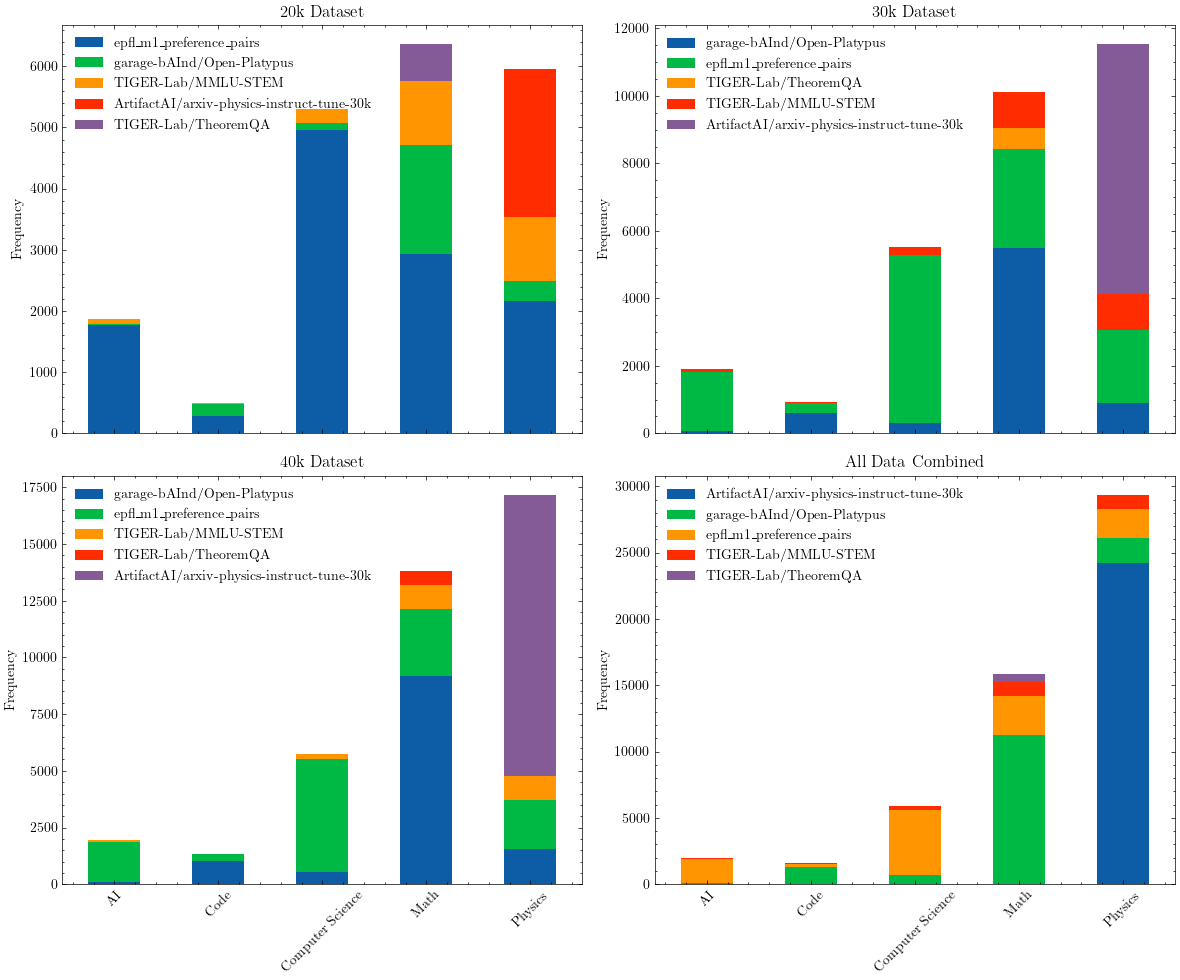

In [19]:
def load_data_and_count(filepath):
    # Load data from jsonlines and count topics by source
    dataset = []
    with jsonlines.open(filepath) as reader:
        for obj in reader:
            dataset.append(obj)
    
    # Initialize and populate the nested dictionary
    topic_source_count = defaultdict(lambda: defaultdict(int))
    for entry in dataset:
        topic = entry['topic']
        source = entry['source']
        topic_source_count[topic][source] += 1
    
    # Convert to DataFrame, transpose, sort by index (source) and return
    df = pd.DataFrame(topic_source_count).fillna(0).transpose()
    df.sort_index(inplace=True)
    return df

# Load data for various datasets
df_1 = load_data_and_count('../data/combined_20k_train.jsonl')
df_2 = load_data_and_count('../data/combined_30k_train.jsonl')
df_3 = load_data_and_count('../data/combined_40k_train.jsonl')
df_all = load_data_and_count('../data/combined_all_train.jsonl')

# Function to plot data
def plot_data(df, title, ax, y_limit=None):
    df.plot(kind='bar', stacked=True, ax=ax)
    ax.legend(loc='upper left')
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(df.index, rotation=45)  
    if y_limit:
        ax.set_ylim([0, y_limit])

# Create a 2x2 grid of subplots with shared x-axis
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True)  

# Plot for each dataframe
datasets = [df_1, df_2, df_3, df_all]
titles = ['20k Dataset', '30k Dataset', '40k Dataset', 'All Data Combined']

for ax, data, title in zip(axs.ravel(), datasets, titles):
    plot_data(data, title, ax)  # Use the custom plotting function

plt.tight_layout()
plt.show()

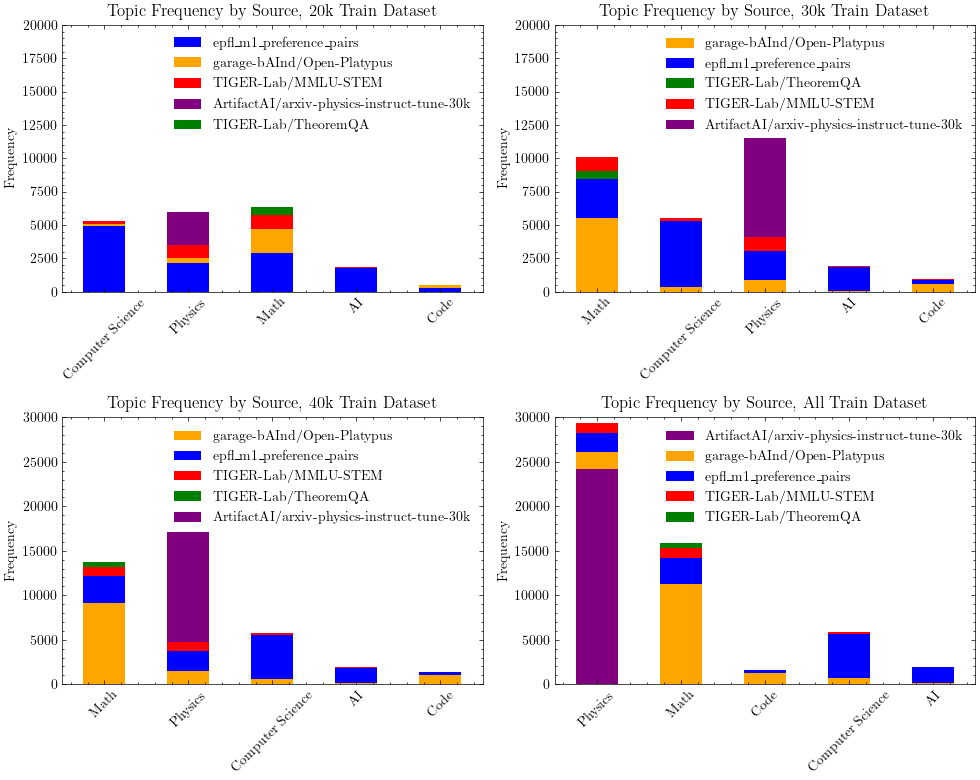

In [23]:
import seaborn as sns

def load_data_and_count(filepath):
    # Load data from jsonlines and count topics by source
    dataset = []
    with jsonlines.open(filepath) as reader:
        for obj in reader:
            dataset.append(obj)
    
    # Initialize and populate the nested dictionary
    topic_source_count = defaultdict(lambda: defaultdict(int))
    for entry in dataset:
        topic = entry['topic']
        source = entry['source']
        topic_source_count[topic][source] += 1
    
    # Convert to DataFrame and return
    return pd.DataFrame(topic_source_count).fillna(0).transpose()

### Step 2: Load Data and Prepare DataFrames
df_1 = load_data_and_count('../data/combined_20k_train.jsonl')
df_2 = load_data_and_count('../data/combined_30k_train.jsonl')
df_3 = load_data_and_count('../data/combined_40k_train.jsonl')
df_all = load_data_and_count('../data/combined_all_train.jsonl')

# Gather all unique sources from all datasets to build a consistent color map
all_sources = set(df_1.columns) | set(df_2.columns) | set(df_3.columns) | set(df_all.columns)

# different sources: 
sources = ['epfl_m1_preference_pairs', 'garage-bAInd/Open-Platypus', 'TIGER-Lab/TheoremQA', 'TIGER-Lab/MMLU-STEM', 'ArtifactAI/arxiv-physics-instruct-tune-30k']
colors = {sources[0]: 'blue', sources[1]: 'orange', sources[2]: 'green', sources[3]: 'red', sources[4]: 'purple'}

plt.style.use('science')

def plot_data(df, title, ax, colors, y_limit=None):
    df.plot(kind='bar', stacked=True, ax=ax, color=[colors[src] for src in df.columns])
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(df.index, rotation=45)
    if y_limit:
        ax.set_ylim([0, y_limit])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

plot_data(df_1, 'Topic Frequency by Source, 20k Train Dataset', axes[0, 0],   colors, 20000)
plot_data(df_2, 'Topic Frequency by Source, 30k Train Dataset', axes[0, 1],   colors, 20000)
plot_data(df_3, 'Topic Frequency by Source, 40k Train Dataset', axes[1, 0],   colors, 30000)
plot_data(df_all, 'Topic Frequency by Source, All Train Dataset', axes[1, 1], colors, 30000)

plt.tight_layout()
plt.show()

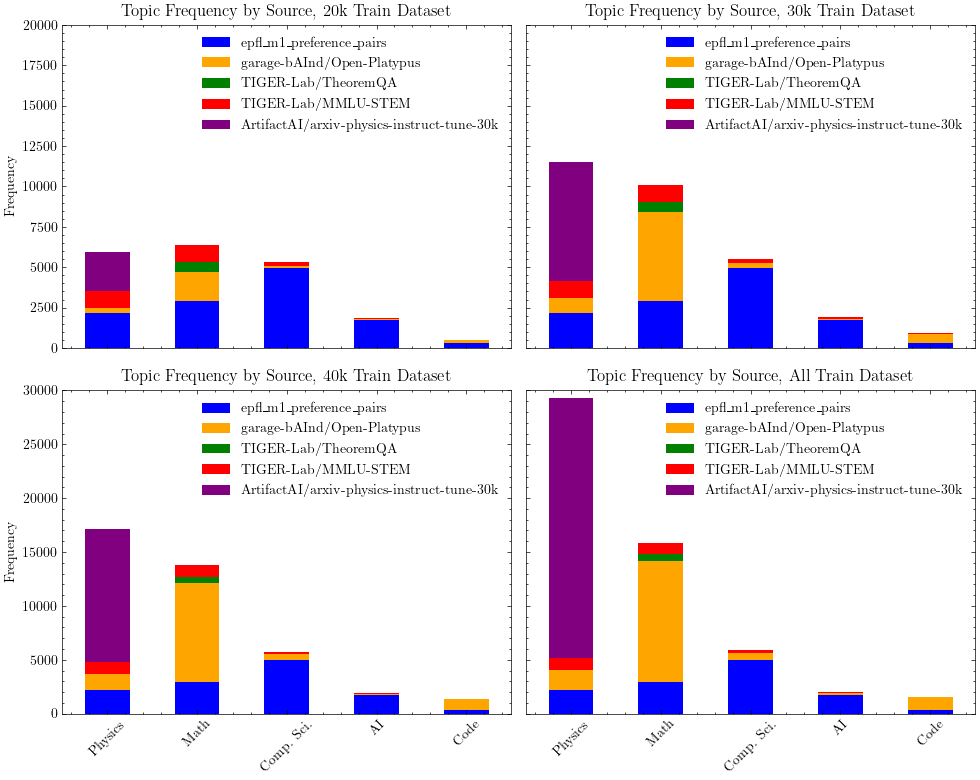

In [10]:
def load_data_and_count(filepath, all_sources, desired_order):
    # Load data from jsonlines and count topics by source
    dataset = []
    with jsonlines.open(filepath) as reader:
        for obj in reader:
            dataset.append(obj)
    
    # Initialize and populate the nested dictionary
    topic_source_count = defaultdict(lambda: defaultdict(int))
    for entry in dataset:
        topic = entry['topic']
        source = entry['source']
        topic_source_count[topic][source] += 1
    
    # Convert to DataFrame, ensure all columns are present, and reorder them
    df = pd.DataFrame(topic_source_count).fillna(0).transpose()
    
    # Ensure all sources are included and in the correct order
    df = df.reindex(desired_order)  # Reorder the DataFrame rows according to the desired topic order
    
    for source in all_sources:
        if source not in df.columns:
            df[source] = 0
    
    return df[all_sources]

# Define the desired order of topics
desired_order = ['Physics', 'Math', 'Computer Science', 'AI', 'Code']

# List of all possible sources in the desired order
all_sources = ['epfl_m1_preference_pairs', 'garage-bAInd/Open-Platypus', 'TIGER-Lab/TheoremQA', 'TIGER-Lab/MMLU-STEM', 'ArtifactAI/arxiv-physics-instruct-tune-30k']
colors = {sources[0]: 'blue', sources[1]: 'orange', sources[2]: 'green', sources[3]: 'red', sources[4]: 'purple'}

# Load data for each dataset and apply the topic ordering
df_1 = load_data_and_count('../data/combined_20k_train.jsonl', all_sources, desired_order)
df_2 = load_data_and_count('../data/combined_30k_train.jsonl', all_sources, desired_order)
df_3 = load_data_and_count('../data/combined_40k_train.jsonl', all_sources, desired_order)
df_all = load_data_and_count('../data/combined_all_train.jsonl', all_sources, desired_order)

plt.style.use('science')

def plot_data(df, title, ax, colors, y_limit=None):
    df.plot(kind='bar', stacked=True, ax=ax, color=[colors[src] for src in df.columns], sharex=True, sharey=True)
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    # Replace "Computer Science" with "Comp. Sci." in xticklabels
    new_labels = [label if label != 'Computer Science' else 'Comp. Sci.' for label in df.index]
    ax.set_xticklabels(new_labels, rotation=45)
    if y_limit:
        ax.set_ylim([0, y_limit])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

plot_data(df_1, 'Topic Frequency by Source, 20k Train Dataset', axes[0, 0], colors, 20000)
plot_data(df_2, 'Topic Frequency by Source, 30k Train Dataset', axes[0, 1], colors, 20000)
plot_data(df_3, 'Topic Frequency by Source, 40k Train Dataset', axes[1, 0], colors, 30000)
plot_data(df_all, 'Topic Frequency by Source, All Train Dataset', axes[1, 1], colors, 30000)

plt.tight_layout()
plt.show()

## Create MCQ Dataset for M2

In [ ]:
def transform_sciq_data(data):
    transformed_data = []
    
    for entry in data:
        question = entry['question']
        correct_answer = entry['correct_answer']
        distractors = [entry['distractor1'], entry['distractor2'], entry['distractor3']]
        
        options = distractors + [correct_answer]
        random.shuffle(options)  # Shuffle to randomize the order of options
        
        option_labels = ['A', 'B', 'C', 'D']
        formatted_options = "\n".join(f"{label}. {option}" for label, option in zip(option_labels, options))
        
        correct_label = option_labels[options.index(correct_answer)]
        
        formatted_question = f"Question: {question}\n\nOptions:\n{formatted_options}\n\nAnswer:"
        
        transformed_data.append({"question": formatted_question, "answer": correct_label})
    
    return transformed_data

input_file_path = "../data/mcq_datasets/SciQ_Dataset.json"
output_file_path = "../data/mcq_datasets/Transformed_SciQ_Dataset.jsonl"

with open(input_file_path, 'r') as file:
    data = json.load(file)

transformed_data = transform_sciq_data(data)

with open(output_file_path, 'w') as file:
    for item in transformed_data:
        json.dump(item, file)
        file.write("\n")

print(f"Data transformed and saved to {output_file_path}")

def transform_deepmind_algebra_data(entry):
    question = entry['question']
    options = entry['options']
    correct_label = entry['correct']
    
    formatted_options = "\n".join(options)
    formatted_question = f"Question: {question}\n\nOptions:\n{formatted_options}\n\nAnswer:"
    
    return {"question": formatted_question, "answer": correct_label}

input_file_path = "../data/mcq_datasets/deepmind_algebra_qa.json"
output_file_path = "../data/mcq_datasets/Transformed_DeepMind_Algebra_QA.jsonl"

transformed_data = []
with open(input_file_path, 'r') as file:
    for line in file:
        entry = json.loads(line.strip())
        transformed_entry = transform_deepmind_algebra_data(entry)
        transformed_data.append(transformed_entry)

with open(output_file_path, 'w') as file:
    for item in transformed_data:
        json.dump(item, file)
        file.write("\n")

print(f"Data transformed and saved to {output_file_path}")

Data transformed and saved to ../data/mcq_datasets/Transformed_SciQ_Dataset.jsonl
Data transformed and saved to ../data/mcq_datasets/Transformed_DeepMind_Algebra_QA.jsonl


In [9]:
def transform_hf_data(dataset):
    transformed_data = []
    
    for entry in dataset:
        question = entry['question']
        options = entry['options']
        answer_index = entry['answer_index']
        
        option_labels = list('ABCDEFGHIJ')[:len(options)]
        formatted_options = "\n".join(f"{label}) {option}" for label, option in zip(option_labels, options))
        
        correct_label = option_labels[answer_index]
        
        formatted_question = f"Question: {question}\n\nOptions:\n{formatted_options}\n\nAnswer:"
        
        transformed_data.append({"question": formatted_question, "answer": correct_label})
    
    return transformed_data

# Example usage
dataset = load_dataset("TIGER-Lab/MMLU-Pro", split='test')
transformed_data = transform_hf_data(dataset)

output_file_path = "../data/mcq_datasets/Transformed_MMLU_Dataset.jsonl"
with open(output_file_path, 'w') as file:
    for item in transformed_data:
        json.dump(item, file)
        file.write("\n")

### Add `explanation` column to both datasets (fill it with "explanation"/"support") from source datasets

In [6]:
# Add the support column to the transformed SciQ data
def transform_sciq_data(data):
    transformed_data = []
    
    for entry in data:
        question = entry['question']
        correct_answer = entry['correct_answer']
        distractors = [entry['distractor1'], entry['distractor2'], entry['distractor3']]
        explanation = entry['support']
        
        options = distractors + [correct_answer]
        random.shuffle(options)  # Shuffle to randomize the order of options
        
        option_labels = ['A', 'B', 'C', 'D']
        formatted_options = "\n".join(f"{label}. {option}" for label, option in zip(option_labels, options))
        
        correct_label = option_labels[options.index(correct_answer)]
        
        formatted_question = f"Question: {question}\n\nOptions:\n{formatted_options}\n\nAnswer:"
        
        transformed_data.append({"question": formatted_question, "answer": correct_label, "explanation": explanation})
    
    return transformed_data

input_file_path = "../data/mcq_datasets/SciQ_Dataset.json"
output_file_path = "../data/mcq_datasets/Transformed_SciQ_Dataset_with_explanation.jsonl"

with open(input_file_path, 'r') as file:
    data = json.load(file)

transformed_data = transform_sciq_data(data)

with open(output_file_path, 'w') as file:
    for item in transformed_data:
        json.dump(item, file)
        file.write("\n")

print(f"Data transformed and saved to {output_file_path}")

# Add the explanation columns to the transformed DeepMind Algebra data

def transform_deepmind_algebra_data(entry):
    question = entry['question']
    options = entry['options']
    correct_label = entry['correct']
    explanation = entry['rationale']
    
    formatted_options = "\n".join(options)
    formatted_question = f"Question: {question}\n\nOptions:\n{formatted_options}\n\nAnswer:"
    
    return {"question": formatted_question, "answer": correct_label, "explanation": explanation}

input_file_path = "../data/mcq_datasets/deepmind_algebra_qa.json"
output_file_path = "../data/mcq_datasets/Transformed_DeepMind_Algebra_QA_with_explanation.jsonl"

transformed_data = []
with open(input_file_path, 'r') as file:
    for line in file:
        entry = json.loads(line.strip())
        transformed_entry = transform_deepmind_algebra_data(entry)
        transformed_data.append(transformed_entry)

with open(output_file_path, 'w') as file:
    for item in transformed_data:
        json.dump(item, file)
        file.write("\n")

print(f"Data transformed and saved to {output_file_path}")




Data transformed and saved to ../data/mcq_datasets/Transformed_SciQ_Dataset_with_explanation.jsonl
Data transformed and saved to ../data/mcq_datasets/Transformed_DeepMind_Algebra_QA_with_explanation.jsonl


### Remove entries with empty `explanation` column

In [3]:
# Deepmind
# Identify and extract entries whose "explanation" column is empty
def process_jsonl(file_path):
    non_empty_entries = []
    empty_count = 0
    
    with open(file_path, 'r') as file:
        for line in file:
            entry = json.loads(line)
            if entry['explanation'].strip() == '':
                empty_count += 1
            else:
                non_empty_entries.append(entry)
    
    return non_empty_entries, empty_count

# Function to write the filtered entries back to a new JSONL file
def write_jsonl(file_path, entries):
    with open(file_path, 'w') as file:
        for entry in entries:
            file.write(json.dumps(entry) + '\n')

# File path for the DeepMind Algebra dataset
file_path = '../data/mcq_datasets/Transformed_DeepMind_Algebra_QA_with_explanation.jsonl'

# Execute the functions
filtered_entries, empty_explanation_count = process_jsonl(file_path)

# Print the count of empty explanations
print(f'Number of entries with an empty explanation: {empty_explanation_count}')

# Save the non-empty entries to a new file (you might want to change the path if needed)
output_file_path = '../data/mcq_datasets/Updated_Transformed_DeepMind_Algebra_QA_with_explanation.jsonl'
write_jsonl(output_file_path, filtered_entries)

Number of entries with an empty explanation: 0


In [5]:
# SciQ
# Identify and extract entries whose "explanation" column is empty
def process_jsonl(file_path):
    non_empty_entries = []
    empty_count = 0
    
    with open(file_path, 'r') as file:
        for line in file:
            entry = json.loads(line)
            if entry['explanation'].strip() == '':
                empty_count += 1
            else:
                non_empty_entries.append(entry)
    
    return non_empty_entries, empty_count

# File path for the DeepMind Algebra dataset
file_path = '../data/mcq_datasets/Transformed_SciQ_Dataset_with_explanation.jsonl'
# Execute the functions
filtered_entries, empty_explanation_count = process_jsonl(file_path)

# Print the count of empty explanations
print(f'Number of entries with an empty explanation: {empty_explanation_count}')

# Save the non-empty entries to a new file (you might want to change the path if needed)
output_file_path = '../data/mcq_datasets/Updated_Transformed_SciQ_Dataset_with_explanation.jsonl'
write_jsonl(output_file_path, filtered_entries)

Number of entries with an empty explanation: 1198


### Remove entries with `explanation` column not related to `question` column (SciQ dataset)

In [12]:
def evaluate_explanation(entry):
    # Construct the prompt using the template
    template = """
Given the following question "{}", please determine if this explanation "{}" is related to the question or not. Respond in this format:
##EXPLANATION\n<explanation>
###RELATED<true_or_false>
"""
    prompt = template.format(entry["question"], entry["explanation"])

    # Create a chat instance and send the prompt
    chat_id = f"chat_{random.randint(0, 999999999999)}"
    chat = Chat.create(chat_id)
    message = chat.ask(content=prompt)
    response_string = str(message)

    # Extract relatedness from the response
    related = "true" in response_string.split("###RELATED")[1].strip().lower()
    return {"related": related}

def load_dataset_from_jsonl(file_path):
    return load_dataset('json', data_files=file_path, split='train')

def process_dataset(dataset):
    processed = dataset.map(evaluate_explanation, batched=False, num_proc=4, desc="Processing entries")
    return processed

def filter_unrelated_entries(processed_dataset):
    return processed_dataset.filter(lambda x: x['related'], batched=False, num_proc=4, desc="Filtering unrelated entries")

def save_to_jsonl(dataset, output_file):
    dataset.to_json(output_file)

# Load dataset
dataset = load_dataset_from_jsonl("../data/mcq_datasets/Updated_Transformed_SciQ_Dataset_with_explanation.jsonl")

# Process dataset
processed_dataset = process_dataset(dataset)

# Filter unrelated entries
filtered_dataset = filter_unrelated_entries(processed_dataset)

# Save the filtered dataset to a new file
#save_to_jsonl(filtered_dataset, "../data/mcq_datasets/Filtered_SciQ_Dataset_with_explanation.jsonl")

Processing entries (num_proc=4):  44%|████▍     | 4609/10481 [22:48<39:32,  2.48 examples/s]  

Server timeout.
Retrying in 10 seconds...


Processing entries (num_proc=4):  67%|██████▋   | 7071/10481 [34:59<17:42,  3.21 examples/s]

Server timeout.
Retrying in 10 seconds...


Processing entries (num_proc=4):  70%|███████   | 7343/10481 [36:25<16:15,  3.22 examples/s]

Server timeout.
Retrying in 10 seconds...


Creating json from Arrow format: 100%|██████████| 10/10 [00:00<00:00, 128.22ba/s]


In [13]:
# Just printing some "related"==False entries to check the quality of the model
def print_unrelated_entries(processed_dataset):
    # Iterate through the dataset and print entries where related is False
    for entry in tqdm(processed_dataset, desc="Inspecting unrelated entries"):
        if not entry['related']:
            print(entry)

print_unrelated_entries(processed_dataset)

Inspecting unrelated entries: 100%|██████████| 10481/10481 [00:00<00:00, 56326.69it/s]

{'question': 'Question: What type of plate boundaries produce huge mountain ranges in the ocean basin?\n\nOptions:\nA. tractional\nB. parallel\nC. coherent\nD. divergent\n\nAnswer:', 'answer': 'D', 'explanation': 'Divergent plate boundaries produce huge mountain ranges under water in every ocean basin.', 'related': False}
{'question': 'Question: Interstitial carbides are produced by the reaction of most transition metals at high temperatures with what element?\n\nOptions:\nA. hydrogen\nB. nitrogen\nC. oxygen\nD. carbon\n\nAnswer:', 'answer': 'D', 'explanation': 'temperatures with electropositive metals such as those of groups 1 and 2 and aluminum produces ionic carbides, which contain discrete metal cations and carbon anions. The identity of the anions depends on the size of the second element. For example, smaller elements such as beryllium and aluminum give methides such as Be2C and Al4C3, which formally contain the C4− ion derived from methane (CH4) by losing all four H atoms as pro